<a href="https://colab.research.google.com/github/michalinahulak/Fake_News_Detection/blob/main/2_FakeandReal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ydata-profiling

In [ ]:
!pip install --upgrade gensim

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install optuna

# Imports

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from wordcloud import WordCloud, STOPWORDS
import zipfile
import string
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

from sentence_transformers import SentenceTransformer

from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ls -la '/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification'

total 2045821
-rw------- 1 root root    3194644 May  2 21:07  1.WELFake_Fake_News.ipynb
-rw------- 1 root root    3725698 May  2 21:34  2.FakeandReal.ipynb
-rw------- 1 root root    3069257 Apr 29 19:49 '3. FakeNewsnet.ipynb'
-rw------- 1 root root 1587898029 Apr 26 22:10  dane_sentencetransformer.csv
-rw------- 1 root root  237145983 Apr 27 09:01  df_downsampled_welfake.csv
-rw------- 1 root root     763760 Apr 22 08:14  fakeandreal_pandasprofiling.html
-rw------- 1 root root   42975911 Apr 12 13:19  fakeandreal.zip
-rw------- 1 root root   62789876 May  2 21:33  Fake.csv
-rw------- 1 root root      36424 Apr 20 19:17  fake_fact.jpg
-rw------- 1 root root     674130 Apr 25 18:53  fakenews_pandasprofiling.html
-rw------- 1 root root    1760511 Apr 12 13:19  fakenews.zip
-rw------- 1 root root       3605 Apr 25 19:32  functions.py
-rw------- 1 root root      36152 Apr 25 12:53  modeling_algorithm.png
-rw------- 1 root root      12558 Apr 25 19:15  modeling_scripts.py
drwx------ 2 root r

In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification


In [9]:
import functions
from functions import generate_word_cloud, remove_stopwords_and_punctuation, tokenize, stem_tokens, create_bow_df, create_b2v_df, split_data

In [10]:
import modeling_scripts
from modeling_scripts import create_logistic_regression, perform_kfold_cross_validation, create_more_complex_nn

# Upload dataset

In [5]:
# Open the ZIP file and extract the two CSV files
with zipfile.ZipFile('fakeandreal.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Read the two CSV files into separate dataframes
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# Add label column and combine dataframes
df_fake['label'] = 0
df_true['label'] = 1
df = pd.concat([df_fake, df_true], axis=0)

# Shuffle the rows in the combined dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Basic info

In [6]:
df.head(3)

,title,text,subject,date,label
0,MSNBC Host Can’t Help But Be Perfectly Sexist...,Tuesday night was a very big night for Democra...,News,"March 16, 2016",0
1,Merkel says Geneva talks should aim to agree s...,"HANOVER, Germany (Reuters) - German Chancellor...",politicsNews,"April 24, 2016",1
2,Rep. Ted Lieu Has A Response To Sean Spicer’s...,Rep. Ted Lieu (D-CA) is one of the loudest and...,News,"March 30, 2017",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("fakeandreal_pandasprofiling.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# check missing value

df.isnull().sum().sort_values(ascending = False)

title      0
text       0
subject    0
date       0
label      0
dtype: int64

# Preprocessing

In [8]:
# remove duplicates
df = df.drop_duplicates()

## Downsampling

In [9]:
df_majority = df[df['label'] == 1]
df_minority = df[(df['label'] == 0)]

df_majority_downsampled = resample(df_majority, replace = True, n_samples = len(df_minority), random_state = 42)
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

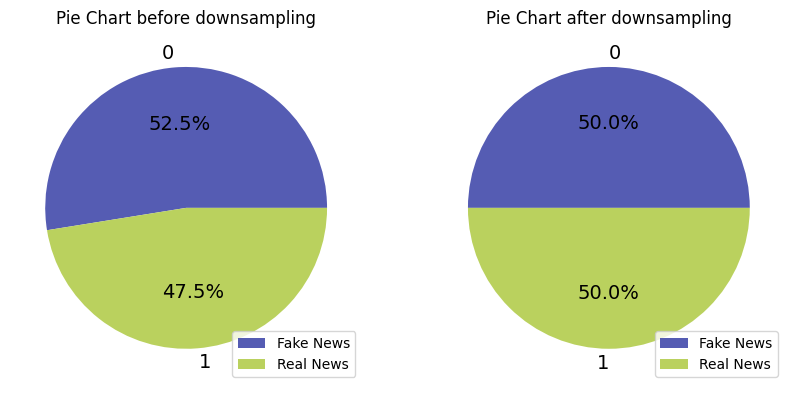

In [ ]:
counts_label = [df['label'].value_counts(), df_downsampled['label'].value_counts()]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, counts in enumerate(counts_label):
    ax[i].pie(counts, 
              labels=counts.index, 
              autopct='%1.1f%%', 
              colors=['#555CB3', '#BAD15E'], 
              textprops={'fontsize': 14})
    ax[i].set_title("Pie Chart " + ("before" if i == 0 else "after") + " downsampling")
    ax[i].legend(labels=['Fake News', 'Real News'], loc='lower right')

plt.show()

## WordCloud

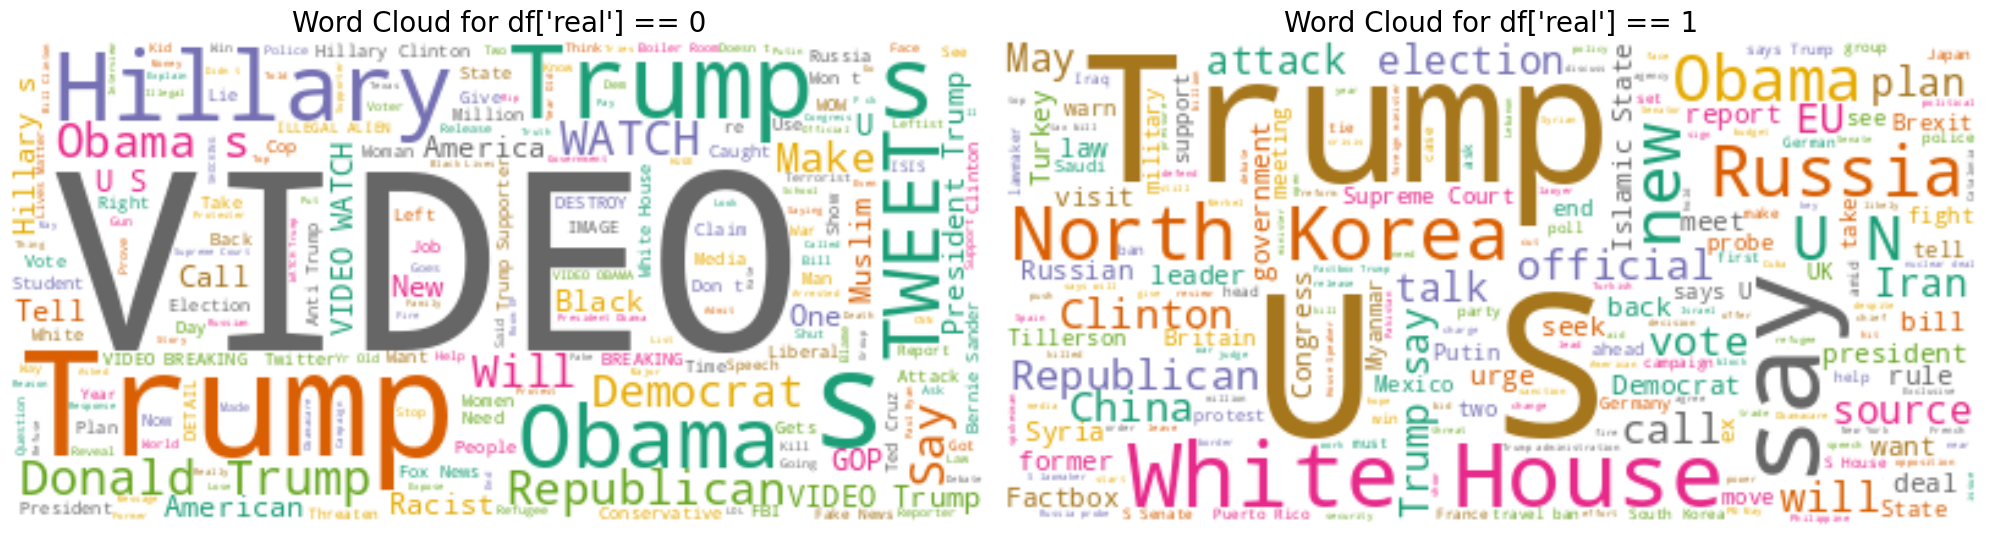

In [ ]:
generate_word_cloud(dataset = df, column1 ='title',  mask=None)

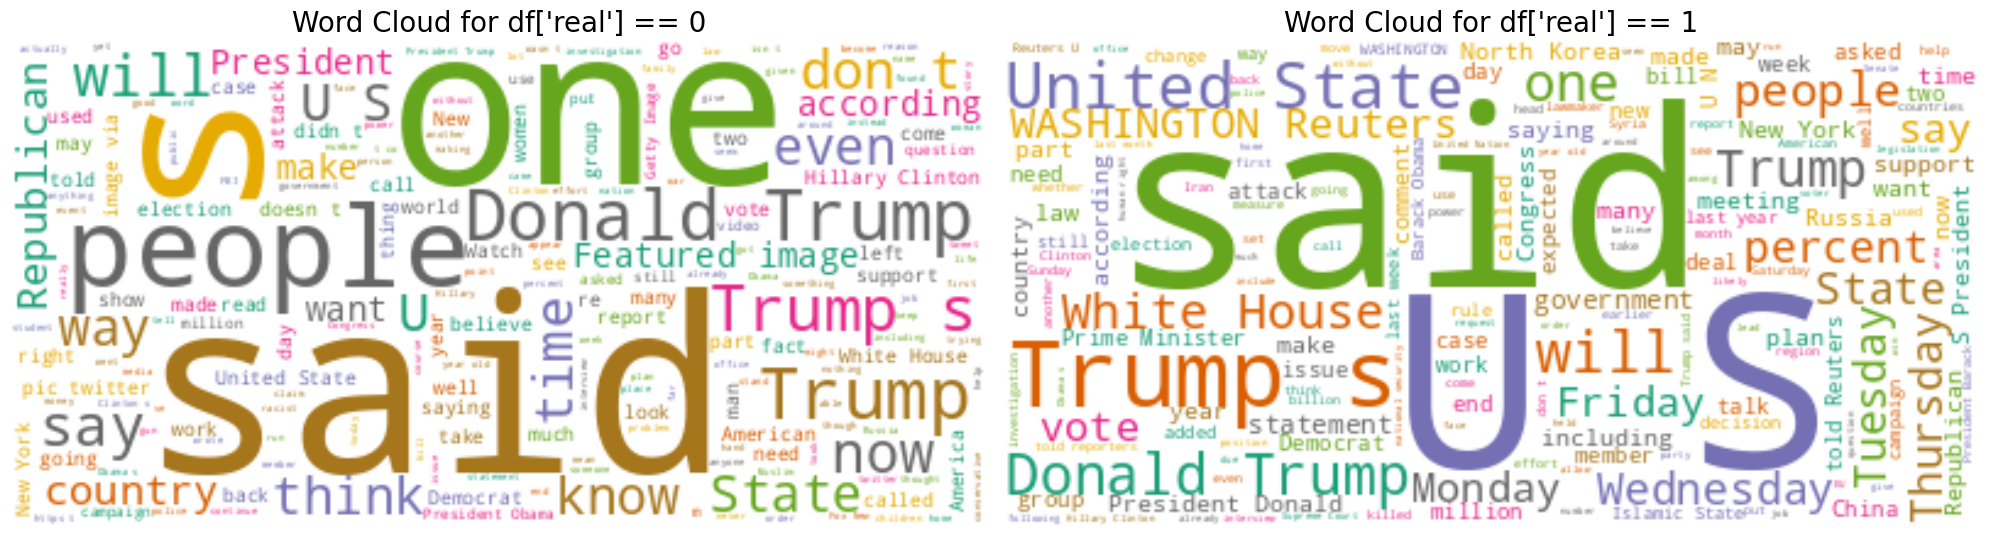

In [ ]:
generate_word_cloud(dataset = df, column1 ='text',  mask=None)

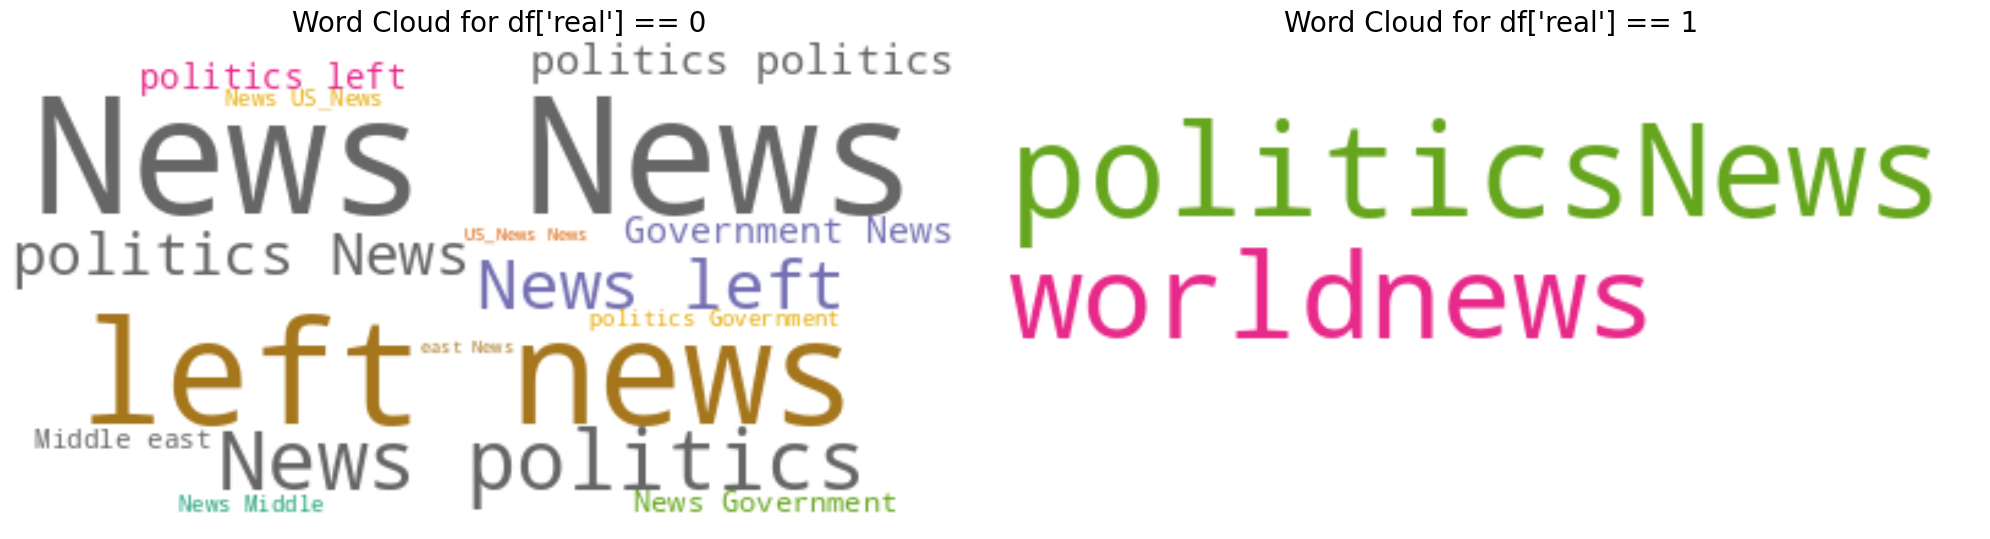

In [ ]:
generate_word_cloud(dataset = df, column1 ='subject',  mask=None)

## Stopwords

In [14]:
df_stopwords = df_downsampled.copy()

In [15]:
remove_stopwords_and_punctuation(df = df_stopwords , columns = ['title', 'text'])

In [ ]:
df_stopwords.head(3)

,title,text,subject,date,label
1,busted marco rubio family lied escaping castro...,marco rubio staff exit building working senato...,News,"February 28, 2016",0
2,frightening power press believe americans call...,remember press used actually report news today...,left-news,"Jun 18, 2016",0
3,watch bill clinton unleash inner child balloon...,bill clinton watched wife accept nomination pr...,News,"July 29, 2016",0


## Tokenizer

In [ ]:
#without stopwords

df_token = df_stopwords.copy()
tokenize(df=df_token, col='title')
tokenize(df=df_token, col='text')
df_token.head(3)

,title,text,subject,date,label
1,"[busted, marco, rubio, family, lied, escaping,...","[marco, rubio, staff, exit, building, working,...",News,"February 28, 2016",0
2,"[frightening, power, press, believe, americans...","[remember, press, used, actually, report, news...",left-news,"Jun 18, 2016",0
3,"[watch, bill, clinton, unleash, inner, child, ...","[bill, clinton, watched, wife, accept, nominat...",News,"July 29, 2016",0


In [ ]:
# with stopwords

df_token_stopwords = df_downsampled.copy()
df_token_stopwords['title'] = df_token_stopwords['title'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
df_token_stopwords['text'] = df_token_stopwords['text'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))

In [ ]:
tokenize(df=df_token_stopwords , col='title')
tokenize(df=df_token_stopwords , col='text')
df_token_stopwords.head(3)

,title,text,subject,date,label
4,"[sweden, is, on, brink, of, collapse…, gun, pu...","[the, politically, correct, country, of, swede...",left-news,"Dec 19, 2015",0
5,"[today, list, of, us, cities, where, “, day, o...","[isn, t, it, great, when, the, day, after, a, ...",left-news,"Jul 15, 2016",0
7,"[what, is, going, on, with, hillary, ’, s, eye...","[hillary, spoke, to, a, very, small, group, of...",politics,"Sep 21, 2016",0


## SnowBall Stemming

In [ ]:
#without stopwords

df_stemm = df_token.copy()
df_stemm['title'] = df_stemm['title'].apply(stem_tokens)
df_stemm['text'] = df_stemm['text'].apply(stem_tokens)
df_stemm.head(3)

,title,text,subject,date,label
4,"[sweden, brink, gun, purchas, way, spray, sell...","[polit, correct, countri, sweden, pay, big, pr...",left-news,"Dec 19, 2015",0
5,"[today, list, citi, day, rage, report, air, fo...","[great, day, major, terror, attack, franc, cit...",left-news,"Jul 15, 2016",0
7,"[go, hillari, relat, parkinson, diseas, video]","[hillari, spoke, small, group, student, templ,...",politics,"Sep 21, 2016",0


In [ ]:
# with stopwords

df_stemm_stopwords = df_token_stopwords.copy()
df_stemm_stopwords['title'] = df_stemm_stopwords['title'].apply(stem_tokens)
df_stemm_stopwords['text'] = df_stemm_stopwords['text'].apply(stem_tokens)
df_stemm_stopwords.head(3)

,title,text,subject,date,label
4,"[sweden, is, on, brink, of, collapse…, gun, pu...","[the, polit, correct, countri, of, sweden, pay...",left-news,"Dec 19, 2015",0
5,"[today, list, of, us, citi, where, “, day, of,...","[isn, t, it, great, when, the, day, after, a, ...",left-news,"Jul 15, 2016",0
7,"[what, is, go, on, with, hillari, ’, s, eyes…c...","[hillari, spoke, to, a, veri, small, group, of...",politics,"Sep 21, 2016",0


## Bag-of-words algorithm

In [ ]:
#without stopwords

df_bow = df_stemm.copy()
df_bow_title = create_bow_df(df=df_bow, col='title')
df_bow_text = create_bow_df(df=df_bow, col='text')

In [ ]:
# with stopwords

df_bow_stopwords = df_stemm_stopwords.copy()
df_bow_stopwords_title = create_bow_df(df=df_bow_stopwords, col='title')
df_bow_stopwords_text = create_bow_df(df=df_bow_stopwords, col='text')

## Bag2Vec algorithm

In [ ]:
#without stopwords

df_b2v = df_stemm.copy()
df_b2v_title = create_b2v_df(df=df_b2v, col='title')
df_b2v_text = create_b2v_df(df=df_b2v, col='text')

In [ ]:
# with stopwords

df_b2v_stopwords = df_stemm_stopwords.copy()
df_b2v_title_stopwords = create_b2v_df(df=df_b2v_stopwords, col='title')
df_b2v_text_stopwords = create_b2v_df(df=df_b2v_stopwords, col='text')


## Sentence Transformer

In [16]:
df_st = df_stopwords.copy()

In [17]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [34]:
title = model.encode(df_st['title'].values.tolist(), convert_to_tensor=True)
# text_sentencetransformer = df_st['text'].apply(lambda x: model.encode(x).tolist())

# Models - 1st root
*   cut stopwords: no
*   tokenize: yes
*   bag-of-words

In [ ]:
# extract X and y
X = pd.concat([df_bow_stopwords_title, df_bow_stopwords_text], axis=1).values
y = df_stemm_stopwords['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

/content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


Best trial:
  Loss: 0.9973
  Params: 
    lr: 0.03441969584978615
    batch_size: 32
    epochs: 44
Training set: loss=0.0000, accuracy=1.0000
Validation set: loss=6.6302, accuracy=0.9336
Test set: loss=6.3316, accuracy=0.9367


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.9960
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9939
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.9961
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9969
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9959
Test accuracy = 0.9957
Average train accuracy = 1.0000
Average validation accuracy = 0.9957


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9994, Validation accuracy = 0.9944
Fold 2: Train accuracy = 0.9999, Validation accuracy = 0.9954
Fold 3: Train accuracy = 0.9992, Validation accuracy = 0.9962
Fold 4: Train accuracy = 0.9997, Validation accuracy = 0.9955
Fold 5: Train accuracy = 0.9997, Validation accuracy = 0.9946
Test accuracy = 0.9960
Average train accuracy = 0.9996
Average validation accuracy = 0.9952


# Models - 2nd root
*   cut stopwords: no
*   tokenize: yes
*   Bag2Vec

In [ ]:
# extract X and y
X = pd.concat([df_b2v_title_stopwords, df_b2v_text_stopwords], axis=1).values
y = df_stemm_stopwords['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

/content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


Best trial:
  Loss: 0.9848
  Params: 
    lr: 0.00011201592696903299
    batch_size: 16
    epochs: 22
Training set: loss=25.0000, accuracy=0.7500
Validation set: loss=47.4588, accuracy=0.5254
Test set: loss=47.0613, accuracy=0.5294


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.8889, Validation accuracy = 0.9808
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9826
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.9805
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9857
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9657
Test accuracy = 0.9661
Average train accuracy = 0.9778
Average validation accuracy = 0.9791


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9917, Validation accuracy = 0.9886
Fold 2: Train accuracy = 0.9904, Validation accuracy = 0.9868
Fold 3: Train accuracy = 0.9895, Validation accuracy = 0.9899
Fold 4: Train accuracy = 0.9887, Validation accuracy = 0.9896
Fold 5: Train accuracy = 0.9942, Validation accuracy = 0.9932
Test accuracy = 0.9889
Average train accuracy = 0.9909
Average validation accuracy = 0.9896


# Models - 3rd root
*   cut stopwords: yes
*   tokenize: no
*   Sentence Transformer

In [35]:
X = title
y = df_st['label'].values

## Logistic Regression with Optuna

In [36]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [37]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Best trial:
  Loss: 0.9259
  Params: 
    lr: 0.0012287131034667814
    batch_size: 64
    epochs: 23
Training set: loss=8.3333, accuracy=0.9167
Validation set: loss=9.2181, accuracy=0.8962
Test set: loss=10.1411, accuracy=0.8860


## Cross validation

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
perform_kfold_cross_validation(X_train,  y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.9255
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9207
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.9217
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9183
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9139
Test accuracy = 0.9194
Average train accuracy = 1.0000
Average validation accuracy = 0.9200


## More complex NN

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

/content/drive/My Drive/Colab Notebooks/Codecool/Fake News Classification/modeling_scripts.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Fold 1: Train accuracy = 0.9379, Validation accuracy = 0.9259
Fold 2: Train accuracy = 0.9480, Validation accuracy = 0.9284
Fold 3: Train accuracy = 0.9402, Validation accuracy = 0.9200
Fold 4: Train accuracy = 0.9449, Validation accuracy = 0.9267
Fold 5: Train accuracy = 0.9335, Validation accuracy = 0.9205
Test accuracy = 0.9323
Average train accuracy = 0.9409
Average validation accuracy = 0.9243


# Models - 4th root
*   cut stopwords: yes
*   tokenize: yes
*   convert to stem: yes
*   bag-of-words

In [ ]:
# extract X and y
X = pd.concat([df_bow_title, df_bow_text], axis=1).values
y = df_stemm['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

/content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification/modeling_scripts.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


Best trial:
  Loss: 0.9967
  Params: 
    lr: 0.0013568430111030791
    batch_size: 32
    epochs: 35
Training set: loss=0.0000, accuracy=1.0000
Validation set: loss=2.0783, accuracy=0.9757
Test set: loss=1.8276, accuracy=0.9784


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.9957
Fold 2: Train accuracy = 1.0000, Validation accuracy = 0.9947
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.9945
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9968
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9960
Test accuracy = 0.9972
Average train accuracy = 1.0000
Average validation accuracy = 0.9956


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9998, Validation accuracy = 0.9941
Fold 2: Train accuracy = 0.9994, Validation accuracy = 0.9956
Fold 3: Train accuracy = 0.9994, Validation accuracy = 0.9960
Fold 4: Train accuracy = 0.9998, Validation accuracy = 0.9949
Fold 5: Train accuracy = 0.9980, Validation accuracy = 0.9936
Test accuracy = 0.9964
Average train accuracy = 0.9993
Average validation accuracy = 0.9949


# Models - 5th root

*   cut stopwords: yes
*   tokenize: yes
*   convert to stem: yes
*   Bag2Vec

In [ ]:
X = pd.concat([df_b2v_title, df_b2v_text], axis=1).values
y = df_stemm['label'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

Best trial:
  Loss: 0.9644
  Params: 
    lr: 7.222311908174454e-05
    batch_size: 32
    epochs: 49
Training set: loss=0.0000, accuracy=1.0000
Validation set: loss=4.4334, accuracy=0.9533
Test set: loss=4.2980, accuracy=0.9547


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.9589
Fold 2: Train accuracy = 0.6667, Validation accuracy = 0.9589
Fold 3: Train accuracy = 0.6667, Validation accuracy = 0.9437
Fold 4: Train accuracy = 1.0000, Validation accuracy = 0.9321
Fold 5: Train accuracy = 1.0000, Validation accuracy = 0.9577
Test accuracy = 0.9570
Average train accuracy = 0.8667
Average validation accuracy = 0.9502


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9747, Validation accuracy = 0.9717
Fold 2: Train accuracy = 0.9756, Validation accuracy = 0.9694
Fold 3: Train accuracy = 0.9820, Validation accuracy = 0.9758
Fold 4: Train accuracy = 0.9831, Validation accuracy = 0.9788
Fold 5: Train accuracy = 0.9818, Validation accuracy = 0.9751
Test accuracy = 0.9788
Average train accuracy = 0.9795
Average validation accuracy = 0.9742


# Similar news

In [10]:
df_similarnews = df.iloc[:10000]

In [11]:
# create the tf-idf vectorizer
vectorizer = TfidfVectorizer()

# fit the vectorizer on the news titles
tfidf_matrix = vectorizer.fit_transform(df_similarnews['title'])

# calculate cosine distance between all pairs of news titles
cosine_sim = 1 - cosine_distances(tfidf_matrix)

In [13]:
# the index of the first article
index = 1

# get the cosine distances of the first article to all other articles
distances = cosine_sim[index]

# sort the distances in descending order
sorted_distances = sorted(enumerate(distances), key=lambda x: x[1], reverse=True)

# print the selected article
print('Selected article:\n', df_similarnews.loc[index, 'title'], '\n')

# print the top 5 most similar articles
for i, distance in sorted_distances[1:6]:
    print(df.loc[i, 'title'])

Selected article:
 Merkel says Geneva talks should aim to agree safe areas in Syria 

German SPD to start talks with Merkel next week if members agree
Geneva process is the only appropriate format to discuss Syria peace: France
Trump discusses safe zones in Syria with Jordan's king: White House
Merkel, Bavaria allies agree on migrant policy: sources
In shift, Merkel backs end to EU-Turkey membership talks
